# ResNet 残差网络
![](https://gitee.com/leekinghou/image/raw/master/img/20211126122859.png)

## 残差块

右图是 ResNet 的基础结构– 残差块（residual block）。 在残差块中，输入可通过跨层数据线路更快地向前传播。

- 串联一个层改变函数类，我们希望能扩大函数类

- 残差块加入快速通道(右边)来得到去$ f(x) = x＋g(x) $的结构

![](https://gitee.com/leekinghou/image/raw/master/img/1637901371095.png)

ResNet 沿用了 VGG 完整的  3×3  卷积层设计。 残差块里首先有 2 个有相同输出通道数的  3×3  卷积层。 每个卷积层后接一个批量归一化层和 ReLU 激活函数。 然后我们通过跨层数据通路，跳过这 2 个卷积运算，将输入直接加在最后的 ReLU 激活函数前。 这样的设计要求 2 个卷积层的输出与输入形状一样，从而可以相加。 如果想改变通道数，就需要引入一个额外的  1×1  卷积层来将输入变换成需要的形状后再做相加运算。 残差块的实现如下：

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

此代码生成两种类型的网络： 一种是在 use_1x1conv=False 、应用 ReLU 非线性函数之前，将输入添加到输出。 另一种是在 use_1x1conv=True 时，添加通过  1×1  卷积调整通道和分辨率。

![](https://gitee.com/leekinghou/image/raw/master/img/1637901500534.png)

下面我们来查看输入和输出形状一致的情况。

In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在增加输出通道数的同时，减半输出的高和宽。

In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型

ResNet 的前两层跟之前介绍的 GoogLeNet 中的一样： 在输出通道数为 64、步幅为 2 的  7×7  卷积层后，接步幅为 2 的  3×3  的最大汇聚层。 不同之处在于 ResNet **每个卷积层后增加了批量归一化层**。

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet 在后面接了 4 个由Inception块组成的模块。 ResNet 则使用 4 个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为 2 的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在 ResNet 加入所有残差块，这里每个模块使用 2 个残差块

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与 GoogLeNet 一样，在 ResNet 中加入全局平均汇聚层，以及全连接层输出。

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有 4 个卷积层（不包括恒等映射的  1×1  卷积层）。 加上第一个  7×7  卷积层和最后一个全连接层，共有 18 层。 因此，这种模型通常被称为 ResNet-18。 通过配置不同的通道数和模块里的残差块数可以得到不同的 ResNet 模型，例如更深的含 152 层的 ResNet-152。 虽然 ResNet 的主体结构跟 GoogLeNet类似，但 ResNet 结构更简单，修改也更方便。这些因素都导致了 ResNet 迅速被广泛使用。 图7.6.4 描述了完整的 ResNet-18。

![](https://gitee.com/leekinghou/image/raw/master/img/1637901837627.png)

在训练 ResNet 之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 训练模型
同之前一样，我们在 Fashion-MNIST 数据集上训练 ResNet。

training on cpu


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/baikal/

KeyboardInterrupt: 

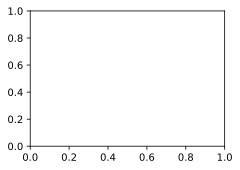

In [12]:
lr, num_epochs, batch_size = 0.05, 10, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())